### Model Training

### 1. Import Data and Required Packages

In [5]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

import warnings
warnings.filterwarnings('ignore')

Importing the training Dataset

In [6]:
df = pd.read_csv("../data/UNSW_NB15_training-set.csv")

In [7]:
df.shape

(175341, 45)

### 2. Data Preprocessing

In [11]:
# making a clean copy
df_prep = df.copy()

In [12]:
# dropping target leakage column, and unnecessary column
df_prep = df_prep.drop(columns=['attack_cat','id'], errors='ignore')

In [13]:
#fixing categorical column
df_prep['service'] = df_prep['service'].replace('-', 'unknown', regex=True)

In [15]:
# Log transformation for skewed features
log_features = ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts']

for col in log_features:
    df_prep[col + '_log'] = np.log1p(df_prep[col])

In [16]:
df_prep.shape

(175341, 48)

In [18]:
#seperate target
y = df_prep['label']

#Auto-detect categorical + numeric columns
df_features = df_prep.drop(columns=['label'])
categorical_cols = df_features.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_features.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical:", categorical_cols)
print("Numeric:", len(numeric_cols), "features")

Categorical: ['proto', 'service', 'state']
Numeric: 44 features


In [20]:
# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

### 3. Train-Test-Split

In [21]:
train_df, test_df = train_test_split(
    df_prep,
    test_size=0.2,
    stratify=df_prep['label'],
    random_state=42
)

### 4. Tranform Train and Test data
Train only on NORMAL data (for anomaly detection)

In [22]:
train_normal_df = train_df[train_df['label'] == 0]

Fit on training data

In [23]:
X_train = preprocessor.fit_transform(train_normal_df)
X_test  = preprocessor.transform(test_df)

y_test = test_df['label'].values

### 4. First Model: Isolation Forest (Core Model)
Train Isolation Forest

In [25]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.3,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train)

,n_estimators,200
,max_samples,'auto'
,contamination,0.3
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


Predict Anamoly Score

In [ ]:
scores = iso.decision_function(X_test)     # higher = normal
preds = iso.predict(X_test)                # 1 = normal, -1 = anomaly
preds_binary = (preds == -1).astype(int)   # convert to 1 = anomaly

Evaluation - Confusion Matrix

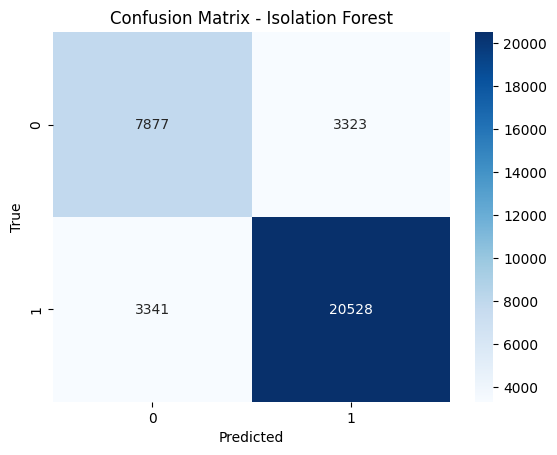

In [30]:
cm = confusion_matrix(y_test, preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix - Isolation Forest")
plt.show()

Classification Report

In [32]:
print(classification_report(y_test, preds_binary, digits=4))

              precision    recall  f1-score   support

           0     0.7022    0.7033    0.7027     11200
           1     0.8607    0.8600    0.8604     23869

    accuracy                         0.8100     35069
   macro avg     0.7814    0.7817    0.7815     35069
weighted avg     0.8101    0.8100    0.8100     35069



ROC-AUC

In [33]:
auc = roc_auc_score(y_test, -scores)  # invert score: higher = anomaly
print("ROC-AUC:", round(auc, 4))

ROC-AUC: 0.8215


ROC curve

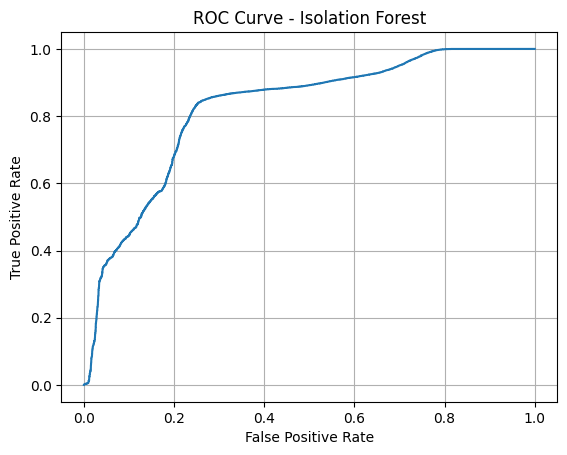

In [34]:
fpr, tpr, _ = roc_curve(y_test, -scores)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest")
plt.grid(True)
plt.show()

Precision-Recall Curve

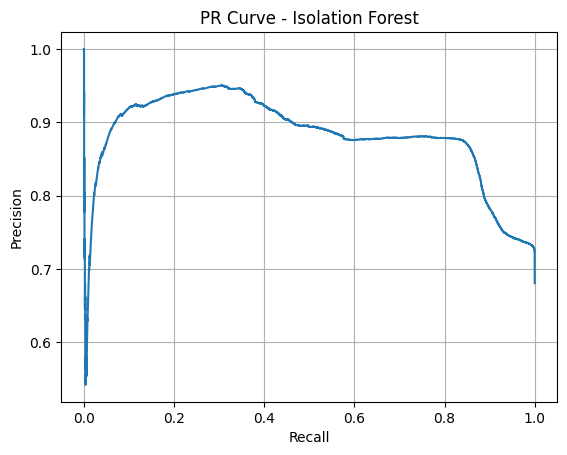

In [35]:
prec, rec, _ = precision_recall_curve(y_test, -scores)

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Isolation Forest")
plt.grid(True)
plt.show()

Anomaly Score Distribution

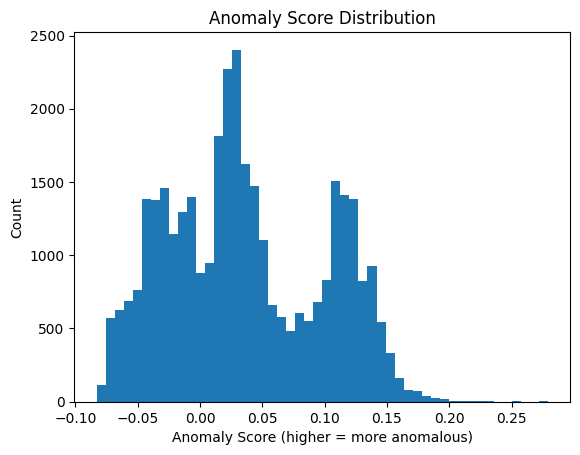

In [36]:
plt.hist(-scores, bins=50)
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score (higher = more anomalous)")
plt.ylabel("Count")
plt.show()

show top anomalous samples

In [37]:
test_df['anomaly_score'] = -scores
top_anomalies = test_df.sort_values('anomaly_score', ascending=False).head(10)
top_anomalies

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,dur_log,sbytes_log,dbytes_log,spkts_log,dpkts_log,anomaly_score
80047,59.977314,tcp,http,CON,998,6676,43400,8906095,127.931704,62,...,21,1,0,1,4.110502,10.678238,16.002247,6.906755,8.806424,0.279088
103845,59.980652,tcp,http,CON,548,3036,23958,4166606,59.735930,62,...,1,1,0,1,4.110557,10.084099,15.242613,6.308098,8.018625,0.278540
65761,59.996758,tcp,http,CON,818,5254,35660,7085342,101.188802,62,...,5,2,0,1,4.110821,10.481813,15.773539,6.708084,8.566935,0.254169
143778,59.986298,tcp,http,FIN,454,2642,19884,3531055,51.595116,62,...,1,1,0,1,4.110649,9.897721,15.077108,6.120297,7.879670,0.252169
86210,59.964836,tcp,smtp,CON,5666,862,7495629,37678,108.847125,62,...,18,1,0,1,4.110297,15.829831,10.536858,8.642415,6.760415,0.231195
89345,59.887993,tcp,smtp,CON,4360,696,5811229,30550,84.407571,62,...,1,1,0,1,4.109036,15.575303,10.327153,8.380457,6.546785,0.231050
163169,59.943161,tcp,smtp,CON,3882,656,5267637,28972,75.688368,62,...,2,1,0,1,4.109942,15.477093,10.274120,8.264363,6.487684,0.229623
80972,59.980972,tcp,smtp,CON,7990,1216,10508068,52700,153.465335,254,...,2,1,0,1,4.110562,16.167654,10.872390,8.986071,7.104144,0.229163
86080,59.947365,tcp,smtp,CON,3818,646,5127548,28404,74.448644,62,...,3,1,0,1,4.110011,15.450138,10.254320,8.247744,6.472346,0.225030
85161,59.903187,tcp,smtp,CON,6430,976,8515713,42602,123.616128,254,...,3,1,0,1,4.109286,15.957424,10.659680,8.768885,6.884487,0.224722



#### Advanced Techniques:

- Using RobustScaler instead of StandardScaler
- Feature Engineering - adding 3 more features
- Hyperparameter Tuning

### 5. Second Model: Autoencoder (Deep Learning)